---

## Facet: Facial Expressions in iMotions's Software Suite

The facial expressions facet in iMotions's software suite harnesses advanced computer vision and machine learning techniques to detect, measure, and analyze facial movements. This module is pivotal for understanding emotional and behavioral responses in real-time.

### Modality
- **Type:** Visual (Video/Image)
- **Purpose:**
  - Decodes subtle facial cues and micro-expressions
  - Provides real-time insights into emotional and affective states
  - Supports a variety of research and practical applications, from consumer behavior analysis to psychological studies

### Feature Extraction
- **Pre-processing:**
  - Implements robust facial landmark detection and alignment to ensure accuracy
- **Analysis:**
  - Utilizes the Facial Action Coding System (FACS) to quantify muscle activations
  - Measures expression intensity, duration, and frequency for comprehensive emotion profiling
- **Applications:**
  - Market research and advertising to gauge consumer reactions
  - Psychological and behavioral studies to analyze emotional responses
  - Human-computer interaction (HCI) to improve user experience and adaptive interfaces

---

### Importing Libraries

In [13]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import (
	Conv2D,
	MaxPooling2D,
	AveragePooling2D,
	Flatten,
	Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

### Loading Data Tensors

In [2]:
with open('../data/tensors.pkl', 'rb') as fr:
    data_tensors = pickle.load(fr)

### Prepare Data into Partitions that make sense

In [3]:
partitions_ = data_tensors[1]
data_all = data_tensors[0]
data_partitions = {partitions_[0]: data_all[0], partitions_[1]: data_all[1], partitions_[2]: data_all[2]}


In [4]:
data_partitions['train'].keys()

dict_keys(['COAVAREP', 'FACET 4.2', 'OpenFace_2.0', 'All Labels', 'glove_vectors', 'OpenSMILE'])

In [5]:
data_partitions['train']['FACET 4.2'].shape

(16327, 50, 35)

### Exploring Training Data Distribution

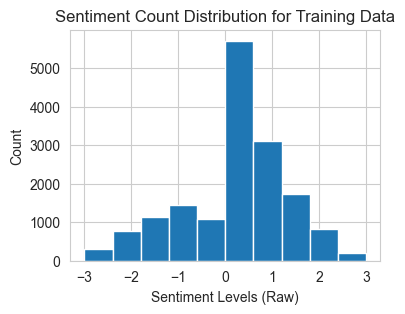

In [6]:
# looking at sentiment probability distribution in train
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(data_partitions['train']['All Labels'][:, :, 0])
ax.set_xlabel("Sentiment Levels (Raw)")
ax.set_ylabel("Count")
ax.set_title('Sentiment Count Distribution for Training Data')
plt.show()

### Extract glove_vectors Only

In [7]:
for k in data_partitions['train'].keys():
    if k == 'FACET 4.2':
        X_train = data_partitions['train'][k]
        X_test = data_partitions['test'][k]
        X_val = data_partitions['valid'][k]
        print(f'{k} has dimension {X_train.shape[1:]}')

FACET 4.2 has dimension (50, 35)


### Preparing Labels for Training, Testing, and Validation

In [8]:
# Use continuous sentiment values for regression:
emo_selected = 0  # sentiment index
Y_train = data_partitions['train']['All Labels'][:, :, emo_selected]
Y_test = data_partitions['test']['All Labels'][:, :, emo_selected]
Y_val = data_partitions['valid']['All Labels'][:, :, emo_selected]

print(Y_train.shape, Y_test.shape, Y_val.shape)


(16327, 1) (4662, 1) (1871, 1)


### Building the CNN Model

In [9]:
input_dim_1 = X_train.shape[1]
input_dim_2 = X_train.shape[2]

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(input_dim_1, input_dim_2, 1)))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# Regression output layer: 1 neuron with linear activation
model.add(Dense(1, activation="linear"))

# Compile the model with a regression loss and metric
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])

/Users/alexanderhsu/Documents/GitHub/11777-EMOji/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Preparing Data for Model Training

In [10]:
# Reshape the data
X_train_reshape = X_train.reshape(-1, input_dim_1, input_dim_2, 1)
Y_train_reshape = np.array(Y_train).reshape(-1, 1)
X_test_reshape = X_test.reshape(-1, input_dim_1, input_dim_2, 1)
Y_test_reshape = np.array(Y_test).reshape(-1, 1)
X_val_reshape = X_val.reshape(-1, input_dim_1, input_dim_2, 1)
Y_val_reshape = np.array(Y_val).reshape(-1, 1)

# Handle potential Inf values in features
X_train_reshape[np.isinf(X_train_reshape)] = np.nan
X_train_reshape = np.nan_to_num(X_train_reshape, nan=np.nanmax(X_train_reshape))
X_test_reshape[np.isinf(X_test_reshape)] = np.nan
X_test_reshape = np.nan_to_num(X_test_reshape, nan=np.nanmax(X_test_reshape))
X_val_reshape[np.isinf(X_val_reshape)] = np.nan
X_val_reshape = np.nan_to_num(X_val_reshape, nan=np.nanmax(X_val_reshape))


### Training the Model

In [11]:
history = model.fit(X_train_reshape, 
                    Y_train_reshape, 
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val_reshape, Y_val_reshape),
                    verbose=2)

Epoch 1/200
511/511 - 8s - 15ms/step - loss: 1.2016 - mae: 0.8253 - val_loss: 1.0377 - val_mae: 0.7643
Epoch 2/200
511/511 - 7s - 14ms/step - loss: 1.1707 - mae: 0.8176 - val_loss: 1.0355 - val_mae: 0.7635
Epoch 3/200
511/511 - 7s - 14ms/step - loss: 1.1535 - mae: 0.8143 - val_loss: 1.0327 - val_mae: 0.7650
Epoch 4/200
511/511 - 8s - 15ms/step - loss: 1.1414 - mae: 0.8112 - val_loss: 1.0285 - val_mae: 0.7644
Epoch 5/200
511/511 - 7s - 15ms/step - loss: 1.1295 - mae: 0.8075 - val_loss: 1.0362 - val_mae: 0.7668
Epoch 6/200
511/511 - 7s - 14ms/step - loss: 1.1219 - mae: 0.8044 - val_loss: 1.0372 - val_mae: 0.7716
Epoch 7/200
511/511 - 7s - 14ms/step - loss: 1.1115 - mae: 0.8014 - val_loss: 1.0308 - val_mae: 0.7686
Epoch 8/200
511/511 - 7s - 14ms/step - loss: 1.1085 - mae: 0.8011 - val_loss: 1.0400 - val_mae: 0.7717
Epoch 9/200
511/511 - 7s - 14ms/step - loss: 1.0970 - mae: 0.7975 - val_loss: 1.0239 - val_mae: 0.7676
Epoch 10/200
511/511 - 7s - 15ms/step - loss: 1.0901 - mae: 0.7952 - val_

In [12]:
# Save the entire model (architecture, weights, and optimizer state)
model.save("../models/facet_unimodal_baseline_regression_model.h5")

### Evaluating Model - Predictions and Metrics

In [14]:
# Predict on the test set
Y_pred = model.predict(X_test_reshape)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test_reshape, Y_pred)

# Compute Pearson correlation coefficient
# Flatten arrays in case they are multi-dimensional
corr, _ = pearsonr(Y_test_reshape.flatten(), Y_pred.flatten())

# Compute R-squared (Coefficient of Determination)
r2 = r2_score(Y_test_reshape, Y_pred)

print("MAE:", mae)
print("Correlation:", corr)
print("R2:", r2)

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MAE: 1.0261921882629395
Correlation: 0.1571212
R2: -0.3923743963241577


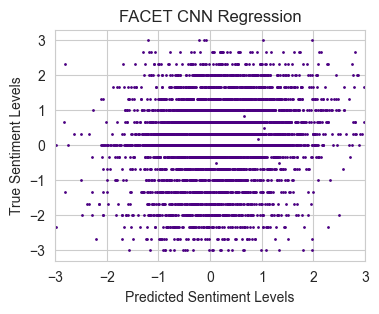

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(Y_pred, Y_test_reshape, s=1, color='indigo')
ax.set_xlabel("Predicted Sentiment Levels")
ax.set_ylabel("True Sentiment Levels")
ax.set_title('FACET CNN Regression')
# clipping to possible sentiment to zoom in on within range predictions
ax.set_xlim([-3, 3])

plt.show()
fig.savefig('../figures/facet_baseline_regression_plot.png', bbox_inches='tight', dpi=300)